## Example: Post-COVID Syndrome (PCS) use case

This notebook shows all the steps to generate PCS KG and the downstream analysis.

In [1]:
# Setting up the working directory
import os

current_dir = os.getcwd()

os.chdir("/Users/yojana/Documents/GitHub/pyBiodatafuse/")
os.getcwd()

'/Users/yojana/Documents/GitHub/pyBiodatafuse'

In [2]:
# Import modules
import pickle

import numpy as np
import pandas as pd
from IPython.display import Image, display

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import disgenet, minerva, opentargets, stringdb
from pyBiodatafuse.constants import (
    DISGENET_DISEASE_COL,
    LITERATURE_DISEASE_COL,
    LITERATURE_DISEASE_OUTPUT_DICT,
)
from pyBiodatafuse.graph import cytoscape, neo4j, rdf, saver
from pyBiodatafuse.graph.rdf import BDFGraph
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

/opt/anaconda3/envs/pybiodatafuse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Entity resolution with BridgeDB

The first step is to input the list of genes to query and retrieve their protein target and synonym identifiers using BridgeDB.

### 1.1. Load the input list and convert it to a dataframe

In [3]:
base_dir = os.path.abspath(os.getcwd())  # Ensures an absolute path
DATA_DIR = os.path.join(base_dir, "examples", "usecases", "PCS", "data")
os.makedirs(DATA_DIR, exist_ok=True)

In [4]:
data_input = pd.read_csv(f"{DATA_DIR}/PCS_gene_list.csv")
print("Total number of genes:", len(data_input.drop_duplicates()))
data_input.head()

Total number of genes: 2023


,identifier
0,LOC729609
1,LOC105374060
2,DMP1
3,PNLIP
4,OR4N3P


### 1.2. Query BridgeDB
The results will be stored in the following directories:

In [5]:
pickle_path = f"{DATA_DIR}/PCS_gene_list.pkl"
metadata_path = f"{DATA_DIR}/PCS_gene_list_metadata.pkl"

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="HGNC",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [6]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 1667


,identifier,identifier.source,target,target.source
0,DMP1,HGNC,Q13316,Uniprot-TrEMBL
1,DMP1,HGNC,HGNC:2932,HGNC Accession Number
2,DMP1,HGNC,DMP1,HGNC
3,DMP1,HGNC,ENSG00000152592,Ensembl
4,DMP1,HGNC,1758,NCBI Gene


## 2. Step-by-step graph generation based on data source of interest


### 2.1. Gene-Disease edges

Here we use the DisGeNET database. To run the following code, you would need the API key from DisGeNET by creating an account [here](https:", "", "disgenet.com", "Profile-area#apiKey)

In [7]:
disgenet_pickle_path = f"{DATA_DIR}/disgenet_df.pkl"
disgenet_metadata_path = f"{DATA_DIR}/disgenet_metadata.pkl"

disgenet_api_key = "1234567890"  # Replace with your API key

if not os.path.exists(disgenet_pickle_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )
    disgenet_df.to_pickle(disgenet_pickle_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_pickle_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

disgenet_df.head()

,identifier,identifier.source,target,target.source,DISGENET_diseases
0,A2ML1,HGNC,144568,NCBI Gene,"[{'disease_name': 'Noonan Syndrome', 'HPO': No..."
1,AAMDC,HGNC,28971,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,..."
2,ABCA1,HGNC,19,NCBI Gene,"[{'disease_name': 'Tangier Disease', 'HPO': No..."
3,ABCB1,HGNC,5243,NCBI Gene,"[{'disease_name': 'Epilepsies', 'HPO': 'HPO:HP..."
4,ABCC6P1,HGNC,653190,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,..."


In [8]:
# Example of data extracted from DisGeNET
pd.DataFrame(disgenet_df[DISGENET_DISEASE_COL][0])

,disease_name,HPO,NCI,OMIM,MONDO,ORDO,EFO,DO,MESH,UMLS,disease_type,disease_umlscui,score,ei,el
0,Noonan Syndrome,None,NCI:C34854,"MIM:176876, MIM:163950",MONDO:0018997,ORDO:648,None,"DOID:0060254, DOID:11983, DOID:11725, DOID:296...",MESH:D009634,UMLS:C0028326,disease,C0028326,0.70,0.833333,None
1,Otitis Media,HPO:HP:0000388,NCI:C34885,None,MONDO:0005441,None,EFO:0004992,DOID:10754,MESH:D010033,UMLS:C0029882,disease,C0029882,0.65,1.000000,None
2,NOONAN SYNDROME 1,None,NCI:C75459,"MIM:163950, MIM:176876","MONDO:0008104, MONDO:0018997",ORDO:648,None,"DOID:0060578, DOID:3490",MESH:D009634,UMLS:C4551602,disease,C4551602,0.40,1.000000,None
3,"OTITIS MEDIA, SUSCEPTIBILITY TO",None,None,"MIM:166760, MIM:610627",MONDO:0008162,None,None,None,None,UMLS:C1833692,phenotype,C1833692,0.40,1.000000,None


### 2.2. Add literature-based data
Genes found to be associated with Post-COVID-19

In [9]:
pcs_associated_genes = pd.read_csv(f"{DATA_DIR}/pcs_associated_genes.csv")
pcs_associated_genes.head()

,Gene
0,CTLA4
1,PTPN22
2,KIT
3,KRAS
4,NF1


#### Define the literature based info

In [10]:
LITERATURE_DISEASE_OUTPUT_DICT = {
    "disease_name": str,
    "UMLS": str,
    "MONDO": str,
    "source": str,
}
literature_disease_attrs = LITERATURE_DISEASE_OUTPUT_DICT.copy()
literature_disease_attrs["disease_name"] = "Long COVID-19"
literature_disease_attrs["UMLS"] = "UMLS:C5433293"
literature_disease_attrs["MONDO"] = "MONDO:0100233"
literature_disease_attrs["source"] = "PMID:37675861"


def get_literature_based_info(gene):
    if gene in pcs_associated_genes["Gene"].values:
        return [literature_disease_attrs]
    else:
        return [{"disease_name": np.nan, "UMLS": np.nan, "MONDO": np.nan, "source": np.nan}]


disgenet_df[LITERATURE_DISEASE_COL] = disgenet_df["identifier"].apply(get_literature_based_info)

disgenet_df.head()

,identifier,identifier.source,target,target.source,DISGENET_diseases,literature_based_info
0,A2ML1,HGNC,144568,NCBI Gene,"[{'disease_name': 'Noonan Syndrome', 'HPO': No...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
1,AAMDC,HGNC,28971,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
2,ABCA1,HGNC,19,NCBI Gene,"[{'disease_name': 'Tangier Disease', 'HPO': No...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
3,ABCB1,HGNC,5243,NCBI Gene,"[{'disease_name': 'Epilepsies', 'HPO': 'HPO:HP...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
4,ABCC6P1,HGNC,653190,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."


In [11]:
disgenet_df[disgenet_df["identifier"] == "DMP1"][LITERATURE_DISEASE_COL]

362    [{'disease_name': 'Long COVID-19', 'UMLS': 'UM...
Name: literature_based_info, dtype: object

In [12]:
print(pcs_associated_genes["Gene"].isin(disgenet_df["identifier"]).sum())

29


### 2.3. Disease-compound edges

We add the following edges using output from DisGeNET and querying OpenTargets.

In [13]:
disease_mapping_df = pd.concat(
    [
        create_harmonized_input_file(disgenet_df, LITERATURE_DISEASE_COL, "MONDO", "UMLS"),
        create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS"),
    ],
    ignore_index=True,
)

disease_mapping_df.head()

,identifier,identifier.source,target,target.source
0,UMLS_C5433293,UMLS,MONDO_0100233,MONDO
1,UMLS_C0029882,UMLS,EFO_0004992,EFO
2,UMLS_C0004153,UMLS,EFO_0003914,EFO
3,UMLS_C0004153,UMLS,EFO_1000819,EFO
4,UMLS_C0010054,UMLS,EFO_0001645,EFO


In [14]:
opentargets_dc_pickle_path = f"{DATA_DIR}/opentargets_disease_compound_df.pkl"
opentargets_dc_metadata_path = f"{DATA_DIR}/opentargets_disease_compound_metadata.pkl"

if not os.path.exists(opentargets_dc_pickle_path):
    (
        opentargets_disease_compound_df,
        opentargets_disease_compound_metadata,
    ) = opentargets.get_disease_compound_interactions(disease_mapping_df, cache_pubchem_cid=True)

    opentargets_disease_compound_df.to_pickle(opentargets_dc_pickle_path)
    with open(opentargets_dc_metadata_path, "wb") as file:
        pickle.dump(opentargets_disease_compound_metadata, file)
else:
    opentargets_disease_compound_df = pd.read_pickle(opentargets_dc_pickle_path)
    with open(opentargets_dc_metadata_path, "rb") as file:
        opentargets_disease_compound_metadata = pickle.load(file)

opentargets_disease_compound_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_disease_compounds
0,UMLS_C0000786,UMLS,EFO_1001255,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1276308', 'drugba..."
1,UMLS_C0000889,UMLS,EFO_1000660,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1431', 'drugbank_..."
2,UMLS_C0001125,UMLS,EFO_1000036,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL306823', 'drugban..."
3,UMLS_C0001175,UMLS,EFO_0000765,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL704', 'drugbank_i..."
4,UMLS_C0001306,UMLS,EFO_1001345,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL628', 'drugbank_i..."


### 2.4. Gene-Compound edges

These edges are extracted from OpenTargets

In [15]:
opentargets_gc_pickle_path = f"{DATA_DIR}/opentargets_gene_compound_df.pkl"
opentargets_gc_metadata_path = f"{DATA_DIR}/opentargets_gene_compound_metadata.pkl"

if not os.path.exists(opentargets_gc_pickle_path):
    (
        opentargets_gene_compound_df,
        opentargets_gene_compound_metadata,
    ) = opentargets.get_gene_compound_interactions(bridgedb_df)

    opentargets_gene_compound_df.to_pickle(opentargets_gc_pickle_path)
    with open(opentargets_gc_metadata_path, "wb") as file:
        pickle.dump(opentargets_gene_compound_metadata, file)
else:
    opentargets_gene_compound_df = pd.read_pickle(opentargets_gc_pickle_path)
    with open(opentargets_gc_metadata_path, "rb") as file:
        opentargets_gene_compound_metadata = pickle.load(file)

opentargets_gene_compound_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_gene_compounds
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'chembl_id': nan, 'drugbank_id': nan, 'compo..."
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'chembl_id': nan, 'drugbank_id': nan, 'compo..."
2,ABCA1,HGNC,ENSG00000165029,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL608', 'drugbank_i..."
3,ABCB1,HGNC,ENSG00000085563,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL1086218', 'drugba..."
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'chembl_id': nan, 'drugbank_id': nan, 'compo..."


### 2.5. Gene-Pathways edges

These edges are extracted from MINERVA, WikiPathways, and OpenTargets

In [16]:
minerva_pickle_path = f"{DATA_DIR}/minerva_df.pkl"
minerva_metadata_path = f"{DATA_DIR}/minerva_metadata.pkl"

if not os.path.exists(minerva_pickle_path):
    minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_pickle_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)
else:
    minerva_df = pd.read_pickle(minerva_pickle_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

minerva_df.head()

,identifier,identifier.source,target,target.source,MINERVA
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
2,ABCA1,HGNC,ENSG00000165029,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
3,ABCB1,HGNC,ENSG00000085563,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."


In [17]:
opentargets_reactome_path = f"{DATA_DIR}/opentargets_reactome_df.pkl"
opentargets_reactome_metadata_path = f"{DATA_DIR}/opentargets_reactome_metadata.pkl"

if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)

else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

opentargets_reactome_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_reactome
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'pathway_label': nan, 'pathway_id': nan}]"
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'pathway_label': nan, 'pathway_id': nan}]"
2,ABCA1,HGNC,ENSG00000165029,Ensembl,[{'pathway_label': 'PPARA activates gene expre...
3,ABCB1,HGNC,ENSG00000085563,Ensembl,[{'pathway_label': 'Abacavir transmembrane tra...
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'pathway_label': nan, 'pathway_id': nan}]"


### 2.6. Gene Ontology annotation

We extract gene annotation from GO through OpenTargets.

In [18]:
opentargets_go_pickle_path = f"{DATA_DIR}/opentargets_go_df.pkl"
opentargets_go_metadata_path = f"{DATA_DIR}/opentargets_go_metadata.pkl"

if not os.path.exists(opentargets_go_pickle_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_pickle_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)

else:
    opentargets_go_df = pd.read_pickle(opentargets_go_pickle_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

opentargets_go_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_go
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'go_id': 'GO:0052548', 'go_name': 'regulatio..."
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'go_id': 'GO:0005737', 'go_name': 'cytoplasm..."
2,ABCA1,HGNC,ENSG00000165029,Ensembl,"[{'go_id': 'GO:0005524', 'go_name': 'ATP bindi..."
3,ABCB1,HGNC,ENSG00000085563,Ensembl,"[{'go_id': 'GO:0008559', 'go_name': 'ABC-type ..."
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'go_id': nan, 'go_name': nan, 'go_type': nan}]"


### 2.7. Protein-Protein Interaction edges

We extract these edges from StringDB.

In [19]:
ppi_pickle_path = f"{DATA_DIR}/string_ppi_df.pkl"
ppi_metadata_path = f"{DATA_DIR}/string_ppi_metadata.pkl"

if not os.path.exists(ppi_pickle_path):
    string_ppi_df, string_ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    string_ppi_df.to_pickle(ppi_pickle_path)
    with open(ppi_metadata_path, "wb") as file:
        pickle.dump(string_ppi_metadata, file)

else:
    string_ppi_df = pd.read_pickle(ppi_pickle_path)
    with open(ppi_metadata_path, "rb") as file:
        string_ppi_metadata = pickle.load(file)

string_ppi_df.head()

,identifier,identifier.source,target,target.source,StringDB_ppi
0,DMP1,HGNC,ENSG00000152592,Ensembl,"[{'stringdb_link_to': 'TNFRSF11B', 'Ensembl': ..."
1,PNLIP,HGNC,ENSG00000175535,Ensembl,"[{'stringdb_link_to': 'LIPE', 'Ensembl': 'Ense..."
2,OR4N3P,HGNC,ENSG00000259435,Ensembl,"[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
3,SLC6A14,HGNC,ENSG00000268104,Ensembl,"[{'stringdb_link_to': 'SLC7A11', 'Ensembl': 'E..."
4,DEFB105A,HGNC,ENSG00000186562,Ensembl,"[{'stringdb_link_to': 'DEFB118', 'Ensembl': 'E..."


## 3. Generating the main graph

### 3.1. Combine (meta)data

In [20]:
combined_df = combine_sources(
    bridgedb_df,
    [
        disgenet_df,
        opentargets_gene_compound_df,
        minerva_df,
        opentargets_reactome_df,
        opentargets_go_df,
        string_ppi_df,
    ],
)
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        disgenet_metadata,
        opentargets_disease_compound_metadata,
        opentargets_gene_compound_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
        string_ppi_metadata,
    ],
)

In [21]:
combined_df.head(4)

,identifier,identifier.source,target,target.source,DISGENET_diseases,literature_based_info,OpenTargets_gene_compounds,MINERVA,OpenTargets_reactome,OpenTargets_go,StringDB_ppi
0,DMP1,HGNC,ENSG00000152592,Ensembl,"[{'disease_name': 'Hypophosphatemic Rickets', ...","[{'disease_name': 'Long COVID-19', 'UMLS': 'UM...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_label': 'ECM proteoglycans', 'pathw...","[{'go_id': 'GO:0005788', 'go_name': 'endoplasm...","[{'stringdb_link_to': 'TNFRSF11B', 'Ensembl': ..."
1,PNLIP,HGNC,ENSG00000175535,Ensembl,[{'disease_name': 'PANCREATIC LIPASE DEFICIENC...,"[{'disease_name': nan, 'UMLS': nan, 'MONDO': n...","[{'chembl_id': 'CHEMBL:CHEMBL175247', 'drugban...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Retinoid metabolism and tr...,"[{'go_id': 'GO:0004806', 'go_name': 'triglycer...","[{'stringdb_link_to': 'LIPE', 'Ensembl': 'Ense..."
2,OR4N3P,HGNC,ENSG00000259435,Ensembl,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_label': nan, 'pathway_id': nan}]","[{'go_id': nan, 'go_name': nan, 'go_type': nan}]","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
3,SLC6A14,HGNC,ENSG00000268104,Ensembl,"[{'disease_name': 'Cystic Fibrosis', 'HPO': No...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Amino acid transport acros...,"[{'go_id': 'GO:0015657', 'go_name': 'branched-...","[{'stringdb_link_to': 'SLC7A11', 'Ensembl': 'E..."


In [22]:
combined_df.to_pickle(f"{DATA_DIR}/combined_df.pkl")
opentargets_disease_compound_df.to_pickle(f"{DATA_DIR}/disease_compound_df.pkl")

In [23]:
combined_df.shape

(2253, 11)

### 3.2. Exporting the combined data and network

In [24]:
pygraph = saver.save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    graph_name="PCS",
    graph_dir=DATA_DIR,
    disease_compound=opentargets_disease_compound_df,
)

Combined DataFrame saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/data/PCS_df.pkl
Metadata saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/data/PCS_metadata.pkl
Building graph: 100%|██████████| 2253/2253 [00:00<00:00, 4596.40it/s]
Graph is built successfully
Graph saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/data/PCS_graph.pkl and /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/data/PCS_graph.gml
Graph saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/data/PCS_graph.edgelist


## 4. Exporting graph to external resources or databases

This code requires you to have a local graph database (Neo4j, Cytoscape or GraphDB) instance open.

> Neo4J:

If you receive the error: `AuthError: {code: Neo.ClientError.Security.Unauthorized} {message: The client is unauthorized due to authentication failure.}`, please make sure you change disable authentication in the config file (dbms.security.auth_enabled=false). See [here](https://stackoverflow.com/questions/53687901/neo4j-cant-log-in-neo-clienterror-security-unauthorized-the-client-is-unauth)

In [25]:
# on neo4j
# neo4j.load_graph(pygraph, uri="bolt://localhost:7687", username="test", password="password")  # change username and password

# on cytoscape
# cytoscape.load_graph(pygraph, network_name="PCS network")

### 4.3. RDF

In [26]:
# Instantiate a BDFGraph
bdf = BDFGraph(
    base_uri="https://biodatafuse.org/pcs_example/",
    version_iri="https://biodatafuse.org/example/bdf_pcs.ttl",
    orcid="https://orcid.org/0000-0002-7683-0452",
    author="Yojana Gadiya",
)

bdf.generate_rdf(combined_df, combined_metadata)  # Generate the RDF from the (meta)data

Building RDF graph: 100%|██████████| 2253/2253 [00:19<00:00, 113.73it/s]


In [27]:
bdf.serialize(
    f"{DATA_DIR}/BDF_PCS_graph.ttl",
    format="ttl",
)

<Graph identifier=Ne0fea409e76a4ace8cb3e381093e8d9e (<class 'pyBiodatafuse.graph.rdf.rdf.BDFGraph'>)>

#### Generate prefixes SHACL

SHACL graphs defining namespaces and prefixes can be loaded into SPARQL endpoints to avoid having to declare prefixes in the query.

In [28]:
# Use without parameters (defaults, does not save file)
bdf.shacl_prefixes()
# or Use with parameters
bdf.shacl_prefixes(
    path=f"{DATA_DIR}/BDF_prefixes.ttl",
    namespaces=None,  # Optional, add more namespaces with a dictionary of {prefix:namespace,}
)

@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] sh:declare [ sh:namespace "https://biodatafuse.org/pcs_example/gene_symbol"^^xsd:anyURI ;
            sh:prefix "gene_symbol_base_node" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/pcs_example/datasource"^^xsd:anyURI ;
            sh:prefix "data_source_base_node" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/2000/01/rdf-schema#"^^xsd:anyURI ;
            sh:prefix "rdfs" ] .

[] sh:declare [ sh:namespace "http://purl.obolibrary.org/obo/so#"^^xsd:anyURI ;
            sh:prefix "so" ] .

[] sh:declare [ sh:namespace "http://xmlns.com/foaf/0.1/"^^xsd:anyURI ;
            sh:prefix "foaf" ] .

[] sh:declare [ sh:namespace "https://identifiers.org/ensembl:"^^xsd:anyURI ;
            sh:prefix "ensembl" ] .

[] sh:declare [ sh:namespace "http://bio2rdf.org/hgnc:"^^xsd:anyURI ;
            sh:prefix "hgnc" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/pcs_examp

<Graph identifier=Nf8f6c867abe64566bbe5493a0b279c01 (<class 'rdflib.graph.Graph'>)>

#### Use [`shexer`](https://github.com/DaniFdezAlvarez/shexer/) to retrieve the RDF shapes

The `shexer` library is used to retrieve the shapes of the graph in [SHACL](https://www.w3.org/TR/shacl/) and [ShEx](https://shex.io/shex-semantics/).

- **SHACL**

@prefix : <http://weso.es/shapes/> .
@prefix bdfo: <https://biodatafuse.org/onto/bdf#> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:DisGeNET_Evidence_Index a sh:NodeShape ;
    sh:property [ a sh:PropertyShape ;
            sh:dataType xsd:double ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path sio:SIO_000300 ],
        [ a sh:PropertyShape ;
            sh:in ( bdfo:DisGeNET_Evidence_Index ) ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdf:type ] ;
    sh:targetClass bdfo:DisGeNET_Evidence_Index .

:DisGeNET_Evidence_Level a sh:NodeShape ;
    sh:property [ a sh:Proper

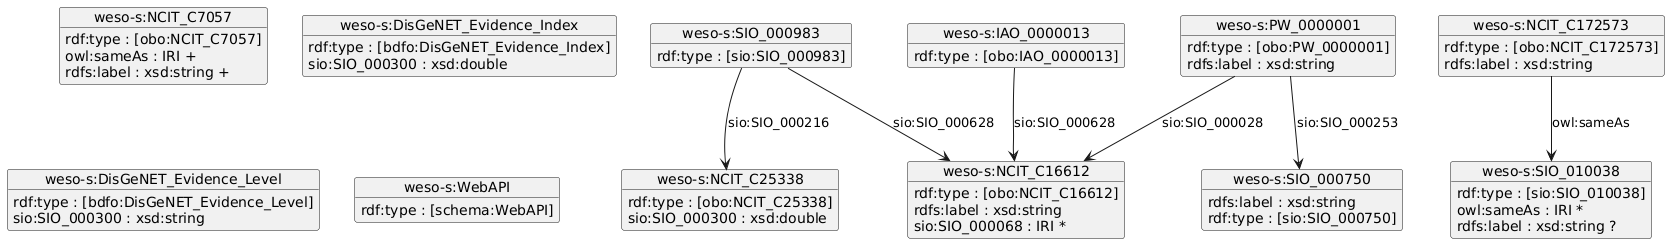

In [29]:
# Use without parameters (defaults)
bdf.shacl()

# Or use with parameters
bdf.shacl(
    path=f"{DATA_DIR}/BDF_example_shacl.ttl",  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=f"{DATA_DIR}/BDF_example_shacl.png",  # Set a path for diagram
)

# Display the UML figure
display(Image(f"{DATA_DIR}/BDF_example_shacl.png"))

- **ShEx**

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX : <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX so: <http://purl.obolibrary.org/obo/so#>
PREFIX bdfo: <https://biodatafuse.org/onto/bdf#>
PREFIX minerva: <https://minerva-net.lcsb.uni.lu/api/>
PREFIX reactome: <https://reactome.org/content/detail/>
PREFIX uniprot: <https://www.uniprot.org/uniprotkb/>
PREFIX ensembl: <http://identifiers.org/ensembl#>
PREFIX graph: <https://biodatafuse.org/pcs_example/>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf

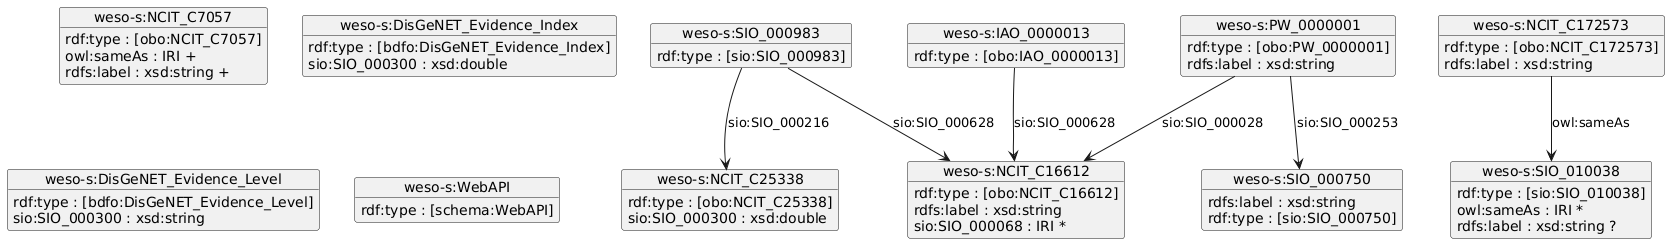

In [30]:
# Use without parameters (defaults)
bdf.shex()

# Or use with parameters
bdf.shex(
    path=f"{DATA_DIR}/BDF_example_shex.ttl",  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=f"{DATA_DIR}/BDF_example_shex.png",  # Set a path for diagram
)

# Display the UML figure
display(Image(f"{DATA_DIR}/BDF_example_shex.png"))

## Figure from the paper

The next figure is a screenshot of a subgraph constructed with the query below in a local instance of GraphDB loaded with the generated BDF RDF graph.

The yellow nodes represent gene-disease associations between Long COVIC-19 and different genes. Green nodes are approved drugs, and purple nodes drugs with no approval.

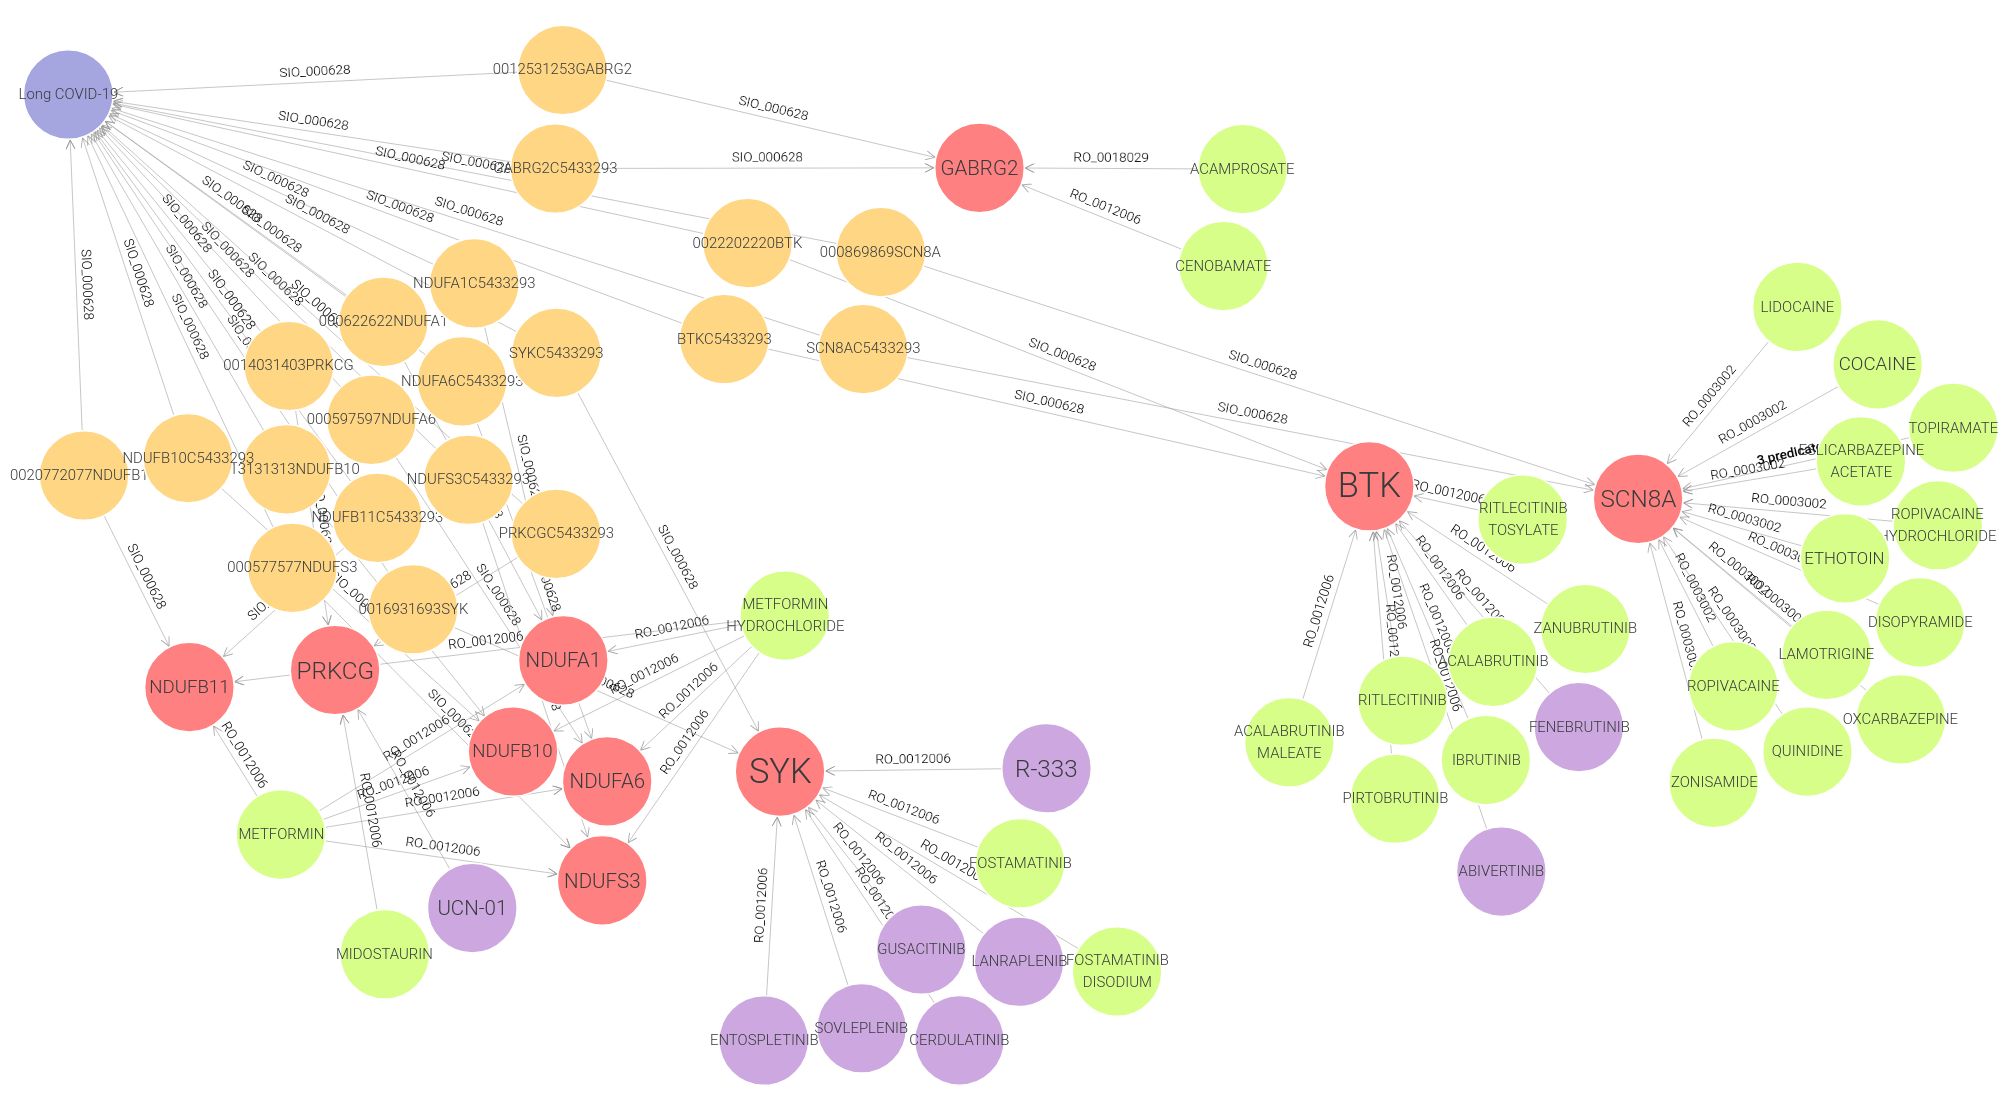

In [32]:
display(Image(f"{DATA_DIR}/graphdb_query_genes_drugs.png"))

In [33]:
!cat examples/usecases/PCS/query_genes_drugs.rq

CONSTRUCT {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?gd a sio:SIO_000983 ;
        sio:SIO_000628 ?gene, ?disease .
    ?disease rdfs:label ?diseaseLabel .
    ?drug ?rel ?gene ;
          rdfs:label ?drugLabel .
} 
WHERE {
    ?gene a obo:NCIT_C16612 ;
          rdfs:label ?geneLabel .
    ?disease rdfs:label ?diseaseLabel .
    VALUES ?disease { obo:C5433293 umls:C5433293 }
    ?drug rdfs:label ?drugLabel ;
          ?rel ?gene .
    ?gd a sio:SIO_000983 ;
        sio:SIO_000628 ?gene, ?disease .
    
    VALUES ?rel {
        obo:RO_0018029    # ANTAGONIST
        obo:RO_0003002    # BLOCKER
        obo:RO_0012006    # INHIBITOR
        obo:RO_0018028    # INVERSE AGONIST
    }
}
